## Test Finite Difference Frequency Domain (FDFD) numerical loss

This notebooks reports on the performance of FDFD algorithm to numerically calculate physical (Maxwell) loss. We do import a solution calculated with FEM in COMSOL and evaluate the numerical loss with FDFD scheme implemented in Pytorch

In [7]:
import torch
from MaxwellNet import MaxwellNet, complex_tensor
import torch.nn.functional as F
from torch import nn

import numpy as np
import math
import os
import json

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
rcParams['font.family'] = ['Calibri','sans-serif']
rcParams['font.weight'] = 'light'
rcParams['axes.labelweight'] = 'light'
rcParams['mathtext.fontset'] = 'stix'
rcParams.update({'font.size': 24})

os.environ['KMP_DUPLICATE_LIB_OK']='True'
from utils import *
import constants

In [3]:
inputs = {
    'directory': './data/diffuser',
    'filename' : 'valid_0_comsol_linear.txt',
    'dataset': 'valid',
    'idx': 0,
    'S0': 1e0,
    'component': 'y',
    'hide_pml': True,
    'cmax' : 2
}

specs_filename = os.path.join(inputs['directory'], 'specs_maxwell.json')
specs = json.load(open(specs_filename))
physical_specs = specs['PhysicalSpecs']
Nx = physical_specs['Nx']
Nz = physical_specs['Nz']

dpl = physical_specs['dpl']
wavelength = physical_specs['wavelength']
nb = physical_specs['nb']
symmetry_x = physical_specs['symmetry_x']
mode = physical_specs['mode']

if physical_specs['high_order'] == 'second':
    pad = 2
else:
    pad = 4

n2 = physical_specs['n2']

delta = wavelength / dpl / nb # Discretization step
k = np.float32(2*math.pi / wavelength) # Vacuum wavenumber
omega = constants.C0*k
x = np.linspace(-(Nx) // 2, (Nx) // 2 - 1, Nx) * delta
z = np.linspace(-(Nz) // 2, (Nz) // 2 - 1, Nz) * delta
zz, xx = np.meshgrid(z, x)

In [4]:
Z, X, field_e, field_h, n_comsol = load_comsol(inputs['filename'], inputs, specs)
_, _, field_ei, field_hi, _ = load_comsol('comsol_background.txt', inputs, specs)

In [5]:
model = MaxwellNet(**specs["NetworkSpecs"], **physical_specs)

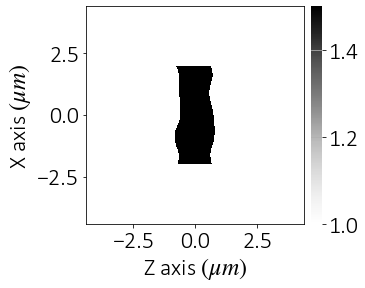

In [6]:
fig, ax = plt.subplots()
plot_XZ(ax,n_comsol,specs, cmap = 'Greys')
plt.grid()
plt.show()

In [46]:
ref_index = torch.zeros((1,1,Nx,Nz), dtype=torch.float32)
ref_index[0,0,:,:] = torch.from_numpy(n_comsol)

ey = complex_tensor(field_e[:,:,1])
ey_i = complex_tensor(field_ei[:,:,1])
ey_s = ey - ey_i

hz = complex_tensor(field_h[:,:,2])
hz_s = hz

hx_i = complex_tensor(field_hi[:,:,0])
hx = complex_tensor(field_h[:,:,0])

hx_s = hx - hx_i
    
#E0 = 1.5035e10
#E0 = 1
#I = E0**2 * ref_index * model.complex_multiplication(ey, model.complex_conjugate(ey))[:, 0:1, :, :] / (
#                    2 * eta0)
#n = ref_index + n2 * I * (ref_index > nb)
S0 = torch.Tensor([1e18])
E0 = torch.sqrt(2 * constants.Z0 / model.nb * S0).unsqueeze(1).unsqueeze(2).unsqueeze(3)
I = E0 ** 2 * ref_index * (ey * ey.conj()).real() / (2 * constants.Z0)

n = ref_index + model.n2 * I * (ref_index > model.nb)
epsilon = (n ** 2)
epsilon = model.padding_replication(F.conv2d(epsilon, model.conv_smooth, padding=0, groups=1))
#epsilon = 1/(padding_replication(F.conv2d(1/epsilon, conv_smooth, padding=0, groups=1)))

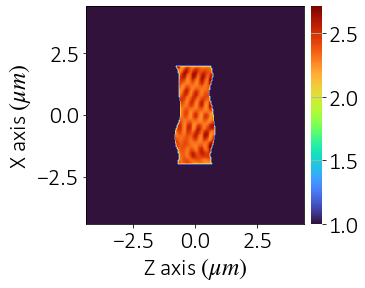

In [47]:
fig, ax = plt.subplots()
plot_XZ(ax,epsilon[0,0,:,:].detach().cpu(),specs, cmap = 'turbo')
plt.grid()
plt.show()

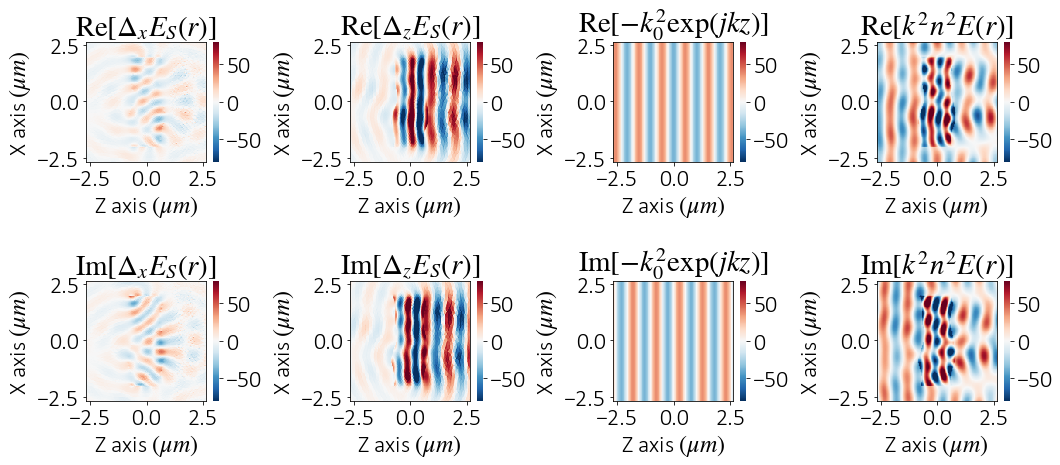

In [35]:
# Compute derivative along x
ey_xx_torch = model.nopad(model.dd_x_pml(model.padding_zero(ey_s)))
ey_xx = ey_xx_torch.to_np()[0]

# Compute derivative along z
ey_zz_torch = model.nopad(model.dd_z_pml(model.padding_zero(ey_s)))
ey_zz = ey_zz_torch.to_np()[0]

# fast oscillating term
#eby_zz = (model.dd_z(ey_i)).to_np()[0]
#eby_zz = model.dd_z_eb.to_np()[0]
#eby_zz = -(k**2)*ey_i.to_np()[0]
#eby_zz = -(k**2)*model.eb.to_np()[0]
eby_zz = (model.dd_z(model.eb)).conj().to_np()[0]

# Compute k0dn term
key_torch = k**2*epsilon*ey
key = key_torch.to_np()[0]

fig, axs = plt.subplots(2,4,figsize=(15,7))

cmax = 80

plot_XZ(axs[0,0],np.real(ey_xx),specs, title=r'$\mathrm{Re}[\Delta_x E_S(r)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
#plot_XZ(axs[0,0],ey_s[0,1,:,:].detach().cpu(),specs, title=r'$Re[\Delta_x E_S(r)]$', cmap = 'jet', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[1,0],np.imag(ey_xx),specs, title=r'$\mathrm{Im}[\Delta_x E_S(r)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[0,1],np.real(ey_zz),specs, title=r'$\mathrm{Re}[\Delta_z E_S(r)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[1,1],np.imag(ey_zz),specs, title=r'$\mathrm{Im}[\Delta_z E_S(r)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[0,2],np.real(eby_zz),specs, title=r'$\mathrm{Re}[-k_0^2\exp(jkz)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[1,2],np.imag(eby_zz),specs, title=r'$\mathrm{Im}[-k_0^2\exp(jkz)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[0,3],np.real(key),specs, title=r'$\mathrm{Re}[k^2n^2 E(r)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)
plot_XZ(axs[1,3],np.imag(key),specs, title=r'$\mathrm{Im}[k^2n^2 E(r)]$', cmap = 'RdBu_r', hide_pml=inputs['hide_pml'], vmin = -cmax, vmax = cmax)

plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(inputs['directory'],"./results/Helmoltz_FDFDLoss.svg"), format="svg")


Loss:  71.167915


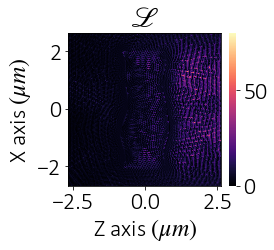

In [36]:
diff = np.abs(ey_xx+ey_zz+eby_zz+key)

mmax = 80

L = np.mean(np.power(diff[model.pml_thickness+pad:-(model.pml_thickness+pad),model.pml_thickness+pad:-(model.pml_thickness+pad)],2))
print('Loss: ',L)
fig, ax = plt.subplots()
plot_XZ(ax,diff,specs, title=r'$\mathscr{L}$', cmap = 'magma', hide_pml=inputs['hide_pml'], vmin = 0, vmax = cmax)

plt.tight_layout()
plt.show()